## Second principles: Fitting a mixture model to inferred 'true' values which is related to an observable with an uncertainty

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind',20)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15) 

import pandas as pd
import pystan
import random

npts = 4000

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))


Lets pull a sample of fractional uncertainties from the true data

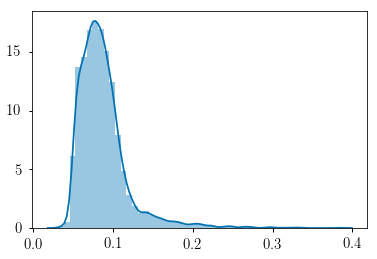

In [16]:
#Define the 'true' parameter values
rQ = .60     #Mixture weighting
rmu = -1.7   #Inlier mean
rsigma = .05 #Inlier spread
rmuo = rmu   #Outlier mean [Not a parameter in the model]
rsigo = .35  #Outlier spread


#Create a series of fractional errors that are similar to those in our data
rf1 = np.random.randn(npts/2)*0.016 + 0.083   #First component is a Gaussian
rf2 = np.random.exponential(.04, npts/2)+.05  #Second component is an exponential
rf_unshuf = np.append(rf1, rf2)
rf = np.array(random.sample(rf_unshuf,npts)) #Shuffle the values before drawing from them

#Drawing the fractional uncertainties for the inlier and outlier sets
fi = rf[:int(npts*rQ)]
fo = rf[int(npts*rQ):int(npts*rQ) + int((1-rQ)*npts)]

sns.distplot(rf)
plt.show()

Lets build our synthetic population no. 1

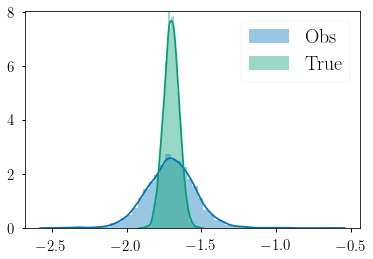

In [17]:
#Building the inlier population
iM_true = np.random.randn(int(npts*rQ)) * rsigma + rmu
iunc = np.abs(fi * iM_true)
iM_obs = iM_true + np.random.randn(int(npts*rQ))*iunc

sns.distplot(iM_obs, label='Obs')
sns.distplot(iM_true, label='True')
plt.legend(fontsize=20)
plt.show()

Now synthetic population no. 2

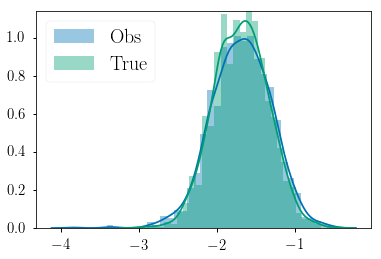

In [18]:
#Building the outlier population
oM_true = np.random.randn(int((1-rQ)*npts)) * rsigo + rmuo
ounc = np.abs(fo * oM_true)
oM_obs = oM_true + np.random.randn(int((1-rQ)*npts))*ounc

sns.distplot(oM_obs, label='Obs')
sns.distplot(oM_true, label='True')
plt.legend(fontsize=20)
plt.show()

Now lets combine them!

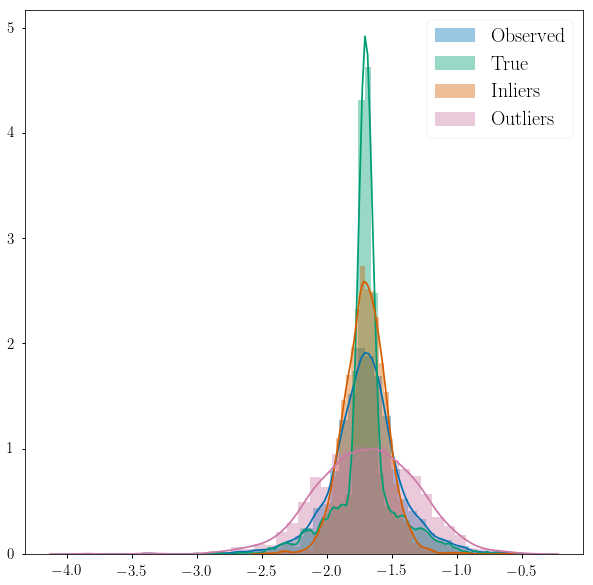

In [19]:
#Create the final synthetic data array
M_obs = np.append(oM_obs, iM_obs)  #Observed data
M_unc = np.append(ounc, iunc)      #Uncertainty on the above
M_true = np.append(oM_true, iM_true)  #The underlying ruth

fig = plt.figure(figsize=(10,10))
sns.distplot(M_obs, label='Observed')
sns.distplot(M_true, label='True')
sns.distplot(iM_obs, label='Inliers')
sns.distplot(oM_obs, label='Outliers')
plt.legend(fontsize=20)
plt.show()

#### They look similar! There is a slight skew to the right in the synthetic data that we need to fix

$p(\theta_{RC}, \{M_i\} | \{\mathcal{D}_i\}) \propto p(\theta_{RC})\prod p(\mathcal{D}_i | \theta_{RC}, M_i)p(M_i | \theta_{RC})$, 

where $\theta_{RC} = \{\mu, \sigma, Q, \sigma_o\}$, $\mathcal{D} = \{\hat{M}, \sigma_{\hat{M}}\}$ is the data, and $M_i$ is the inferred values of $\hat{M}$.

In [6]:
second = '''
data{
    int<lower=0> N; 
    real Mobs[N];  //Observed data
    real Munc[N];  //Uncertainties on observed data
}
parameters {
    real mu;
    real<lower=0.> sigma;
    real<lower = 0., upper=1.> Q;
    real<lower=.3> sigo;
    
    real Mtrue_std[N];   //Transformed true value of M
}
transformed parameters {
    real Mtrue[N];      //True value of M
    real tsigo;         //Transformed outlier spread
    
    for (n in 1:N){     //Transforming into true M space
        Mtrue[n] = mu + sigma*Mtrue_std[n]; 
    }
    tsigo = sigo/sigma; //Transforming into transform space
}
model {
    mu ~ uniform(-1.9, -1.5); //p(theta)
//    sigma ~ normal(0.1, 0.05);
    sigma ~ uniform(0., .3);//''
//    sigo ~ uniform (.3, 3.);  //''
    sigo ~ normal(1.5, .5);
    Q ~ uniform(0., 1.);      //''

    Mobs ~ normal(Mtrue, Munc);  //p(D | theta, M)
    
    //p(M | theta)
    for (n in 1:N)
        target += log_mix(Q,
                    normal_lpdf(Mtrue_std[n] | 0, 1),
                    normal_lpdf(Mtrue_std[n] | 0, tsigo));
}
'''
sm = pystan.StanModel(model_code=second)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb2a15c1e0d7c1a8fb5a3d2c5e60b549 NOW.


In [7]:
data = {'N': npts,
       'Mobs': M_obs,
       'Munc' : M_unc}
init = {'mu' : rmu,
      'sigma': rsigma,
       'sigo': rsigo,
       'Q' : rQ}
fit = sm.sampling(data=data, iter=10000, chains=4, init = [init, init,init, init])

/usr/local/lib/python2.7/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


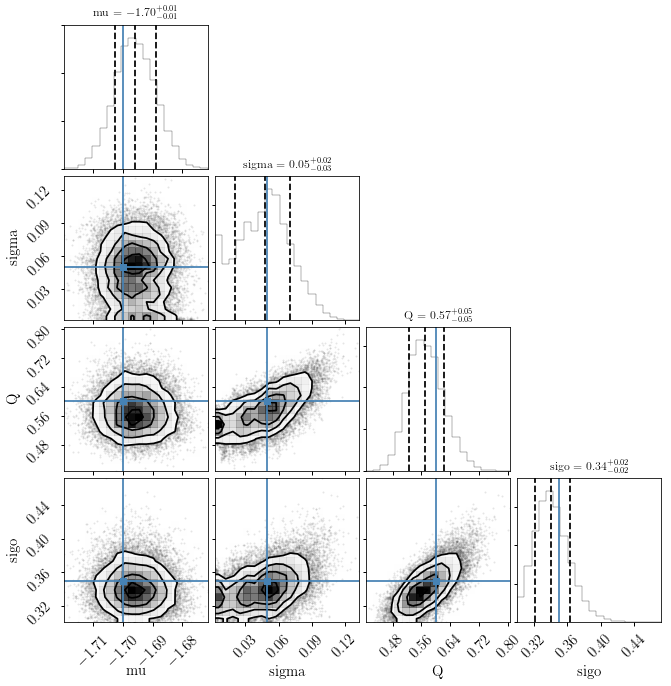

In [8]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['sigo']]).T
truths=[rmu, rsigma, rQ, rsigo]
corner.corner(chain,labels=['mu','sigma','Q','sigo'],\
                  truths=truths,\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

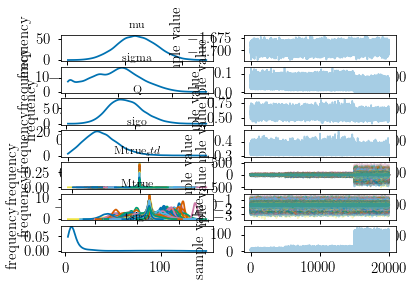

In [9]:
fit.plot()
plt.show()

In [10]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
sigo = (np.median(fit['sigo']))
Q = np.median(fit['Q'])

x = np.linspace(M_obs.min(), M_obs.max(), 1000)
fg = normal(x, mu, sigma)
bg = normal(x, mu, sigo)
L = Q*fg + (1-Q)*bg
rL = rQ * normal(x, rmu, rsigma) + (1-Q)*normal(x, rmu, rsigo)

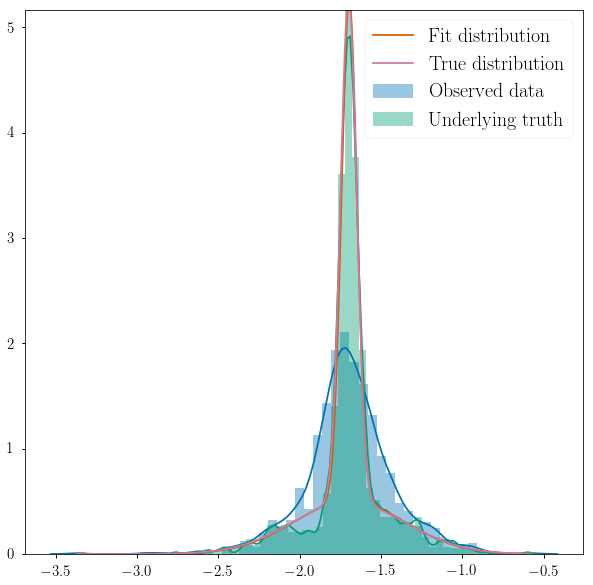

In [11]:
fig = plt.figure(figsize=(10,10))
sns.distplot(M_obs, label='Observed data')
sns.distplot(M_true, label='Underlying truth')
plt.plot(x, L, label='Fit distribution')
plt.plot(x, rL, label='True distribution')
plt.legend(fontsize=20)
plt.show()

In [12]:
print(fit)

Inference for Stan model: anon_model_bb2a15c1e0d7c1a8fb5a3d2c5e60b549.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               -1.7  1.7e-4 6.9e-3  -1.71   -1.7   -1.7  -1.69  -1.68 1597.0    1.0
sigma            0.05  8.4e-3   0.02 3.3e-3   0.03   0.05   0.06   0.09    8.0   1.23
Q                0.57  6.3e-3   0.05   0.48   0.54   0.57   0.61   0.68   64.0   1.06
sigo             0.34  1.8e-3   0.02   0.31   0.33   0.34   0.36   0.39  142.0   1.02
Mtrue_std[0]    -8.76    3.92  21.45  -80.5  -7.82  -2.99  -0.67   1.24   30.0   1.13
Mtrue_std[1]    -0.52    0.09   4.93  -7.07  -0.98  -0.16   0.63   3.54 2849.0   1.01
Mtrue_std[2]    -8.71    4.61  23.07 -83.94  -7.26  -2.13  -0.38   1.61   25.0   1.18
Mtrue_std[3]      0.1    0.05   3.64  -3.07  -0.67   0.05   0.76   3.53 6102.0    1.0
Mtrue_std[4]    -4.13    1.54  12.5

[1.0030192  1.23242486 1.05844787 ... 1.00048742 1.39431054 1.38761814]
Total number of Rhats: 2006
Total number of Rhats with the NaN values removed: 2006


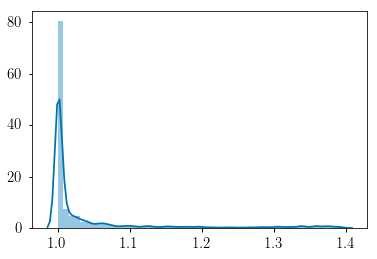

In [13]:
s = fit.summary()
print(s['summary'][:,-1])
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
sns.distplot(rhatfin)
plt.show()

# Code comparing synthetic to my true data

In [14]:
import sys
sys.exit()

SystemExit: 

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
sns.distplot(M, label='Observed data')
sns.distplot(M_obs, label='Synthetic data')
plt.legend(fontsize=15)
plt.show()

In [ ]:
sfile = '../data/KepxDR2/rcxyu18.csv'
df = pd.read_csv(sfile,index_col=0)
M = df.ast_MKs
tau = df.ast_M_err
f = np.abs(tau/M)

In [ ]:
sns.distplot(f)
plt.show()